# ENSF 544 Data Science for Software Engineers
## Phase 1
#### By: Kyle Friedt, Erslan Salman, Kelvin Tran and Avneet Gill

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re

# returns array of addresses and postal codes of restuarants 
def get_addresses(url):
    addresses = []
    postalcodes = []
    
    zomato_html = get_page_html(url)
    parser = BeautifulSoup(zomato_html, 'html.parser')
    address_tag = parser.find_all("div", class_ = "col-m-16 search-result-address grey-text nowrap ln22")
    
    for address in address_tag:
        postal = None
        temp  = address.get_text()
        temp = temp.strip("\n")
        temp = temp.strip()
        
        #looks for 6 digit postal code in Canadian format
        if re.search('[A-Za-z]\d[A-Za-z][ -]?\d[A-Za-z]\d$',temp) != None:
            postal = re.findall('[A-Za-z]\d[A-Za-z][ -]?\d[A-Za-z]\d$',temp)[0]
            temp = temp.replace(postal,"")
            postal = postal.replace(" ","")
            postal = postal.replace("-","")
            
        #looks for 3 digit postal code and removes it
        elif re.search('[A-Za-z]\d[A-Za-z]$',temp) != None:
            postal = re.findall('[A-Za-z]\d[A-Za-z]',temp)[0]
            temp = temp.replace(postal,"")
            
        addresses.append(temp)
        postalcodes.append(postal)
 
    return addresses, postalcodes

In [4]:
def get_titles(url):
    titles = []

    zomato_html = get_page_html(url)
    parser = BeautifulSoup(zomato_html, 'html.parser')
    
    title_tag = parser.find_all("a", class_ = "result-title" )
    
    for title in title_tag:
        temp  = title.get_text()
        temp = temp.strip("\n")
        temp = temp.strip()
        titles.append(temp)
    
    return titles


In [5]:
# gets the average rating and the number of ratings for each restaurant on the page
def get_rating(page_url):
    zomato_html = get_page_html(page_url)
    parser = BeautifulSoup(zomato_html, 'html.parser')
    
    rows = parser.find_all("div", class_="search-snippet-card")
    rating_list = []
    num_rating_list = []
    for row in rows:
        rating = row.find("span", class_="rating-value")
        if rating is not None:
            rating = float(rating.text)
        num_ratings = row.find("span", class_="review-count")
        if num_ratings is not None:
            num_ratings = int(re.search("([0-9]*)",num_ratings.text.strip().replace(',','').replace("(",'')).group(1))
        rating_list.append(rating)
        num_rating_list.append(num_ratings)
    
    return rating_list, num_rating_list

In [6]:
# gets an array of cuisine types for each restaurant on the page
def get_cuisines(page_url):
    zomato_html = get_page_html(page_url)
    parser = BeautifulSoup(zomato_html, 'html.parser')
    
    rows = parser.find_all("div", class_="search-snippet-card")
    cuisine_list = []
    
    for row in rows:
        cuisines = []
        cuisine_tag = row.find("span", text = "Cuisines: ")
        #print(cuisine_tag)
        #print('test')
        if cuisine_tag is not None:
            for cuisine in cuisine_tag.parent.find_all('a'):
                #print(cuisine.text)
                #print('test')
                cuisines.append(cuisine.text)
                
        cuisine_list.append(cuisines)
        #print(cuisine_list)
        #print('test')
    return cuisine_list

In [7]:
def get_next_page(parser):
    links_array = []
    
    next_page = parser.find("a", class_="paginator_item next item")
    next_page = "https://www.zomato.com" + str(next_page['href'])
    next_page = next_page.split("=")
    stripped = next_page[0]
    return stripped

def get_number_of_pages(parser):
    next_page = parser.find("div", class_="col-l-4 mtop pagination-number")
    next_page = next_page.find_all('b')
    number = next_page[1].get_text()
    return number 

def get_all_links(url,number):
    links = []
    links.append(url)
    url_ = url + "="
    
    for x in range(2,int(number)+1):
        new_link = url_+str(x)
        links.append(new_link)
        
    return links
    
def get_page_html(url):    
    headers = {"User-Agent":"Mozilla/5.0"}
    source=requests.get(url, headers=headers).text
    return source

In [8]:
def get_resturant_data(parser):
    url = get_next_page(parser)
    number = get_number_of_pages(parser)
    links = get_all_links(url, number)
    titles = []
    addresses = []
    postal_codes = []
    ratings = []
    num_ratings = []
    cuisines = []
    
    for link in links:
        title = get_titles(link)
        titles = titles + title
        
        address, postal = get_addresses(link)
        addresses.extend(address)
        postal_codes.extend(postal)
        
        rating,num_rating = get_rating(link)
        ratings.extend(rating)
        num_ratings.extend(num_rating)
        
        cuisine = get_cuisines(link)
        cuisines.extend(cuisine)
               
        print("loading...")
    
    df = pd.DataFrame(titles, columns = ['name'])
    df['address'] = addresses
    df['postal_code'] = postal_codes
    df['rating'] = ratings
    df['num_ratings'] = num_ratings
    df['cuisines'] = cuisines
    return df



In [9]:
def clean_name(x):
    x = re.sub('&', 'and', x)
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    return x

def clean_name_column(df):
    df.name = df.name.apply(clean_name)
    return df

In [10]:
#CALGARY
calgary_url = "https://www.zomato.com/calgary/restaurants"
calgary_html = get_page_html(calgary_url)
calgary_parser = BeautifulSoup(calgary_html, 'html.parser')

calgary_df = get_resturant_data(calgary_parser)
calgary_df = clean_name_column(calgary_df)
calgary_df

#TORONTO
toronto_url = "https://www.zomato.com/toronto/restaurants"
toronto_html = get_page_html(toronto_url)
toronto_parser = BeautifulSoup(toronto_html, 'html.parser')

toronto_df = get_resturant_data(toronto_parser)
toronto_df = clean_name_column(toronto_df)

#MONTREAL
montreal_url = "https://www.zomato.com/montreal/restaurants"
montreal_html = get_page_html(montreal_url)
montreal_parser = BeautifulSoup(montreal_html, 'html.parser')

montreal_df = get_resturant_data(montreal_parser)
montreal_df = clean_name_column(montreal_df)

loading...
loading...
loading...
loading...
loading...
loading...
loading...
loading...
loading...
loading...


,name,address,postal_code,rating,num_ratings,cuisines
0,oeb breakfast co,"825 1 Ave NE, Bridgeland, Calgary",T2E3J6,4.9,1463,"[American, Diner]"
1,una pizza and wine,"618 17 Avenue SW, Calgary",T2S0B4,4.6,1708,"[Italian, Pizza]"
2,notable,"4611 Bowness Rd NW, Calgary",T3B0S4,4.4,1297,[Canadian]
3,charcut roast house,"899 Centre St S, Calgary",T2G1B8,4.4,1464,"[European, French, Tapas]"
4,blue star diner,"809 1 Ave NE, Calgary",T2E0C1,4.6,967,"[Breakfast, Burger]"
...,...,...,...,...,...,...
145,pigeonhole,"306 17th Ave SW, Calgary",T2S0A8,3.8,123,"[Tapas, Bar Food]"
146,1410 bier haus,"1410 17 Ave SW, Calgary",T2T0C3,4.1,424,[Bar Food]
147,grumans catering and delicatessen,"230 - 11 Avenue SE, Calgary",T2G0X8,4.2,230,"[Deli, American]"
148,smashburger,2790 32nd Avenue Ne,T1Y5S5,4.2,386,[Burger]


### Run this to generate CSV from Zomato DFs

In [11]:
calgary_df.to_csv("calgary.csv",index = False)
toronto_df.to_csv("toronto.csv",index = False)
montreal_df.to_csv("montreal.csv",index = False)

### Run this if you already have a csv on your local Machine and dont want to query again

In [2]:
#CALGARY
import pandas as pd
calgary_csv = pd.read_csv("calgary.csv")
calgary_csv['cuisines'] = calgary_csv['cuisines'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))

calgary_df = calgary_csv
calgary_df

,name,address,postal_code,rating,num_ratings,cuisines
0,oeb breakfast co,"825 1 Ave NE, Bridgeland, Calgary",T2E3J6,4.9,1463.0,"[American, Diner]"
1,una pizza and wine,"618 17 Avenue SW, Calgary",T2S0B4,4.6,1708.0,"[Italian, Pizza]"
2,notable,"4611 Bowness Rd NW, Calgary",T3B0S4,4.4,1297.0,[Canadian]
3,charcut roast house,"899 Centre St S, Calgary",T2G1B8,4.4,1464.0,"[European, French, Tapas]"
4,blue star diner,"809 1 Ave NE, Calgary",T2E0C1,4.6,967.0,"[Breakfast, Burger]"
...,...,...,...,...,...,...
2994,masala twistz,"175 Chestermere Station Way, Chestermere",T1X1V3,NaN,NaN,[Indian]
2995,little caesars,"100 Marina Drive, Chestermere",T1X1N2,NaN,NaN,[Pizza]
2996,edo japan,"175 Chestermere Station Way, Suite 504, Cheste...",T1X0A4,NaN,NaN,"[Fast Food, Japanese]"
2997,balzac diner,"10070 Highway 566, Balzac, Alberta",NaN,NaN,NaN,[Canadian]


In [3]:
#TORONTO
toronto_csv = pd.read_csv("toronto.csv")
toronto_csv['cuisines'] = toronto_csv['cuisines'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))

toronto_df = toronto_csv
toronto_df 


,name,address,postal_code,rating,num_ratings,cuisines
0,auberge du pommier,"4150 Yonge St., Toronto, ON",M2P2C6,4.5,644.0,[French]
1,terroni,"57A Adelaide Street East, Toronto",NaN,4.0,564.0,"[Italian, Pizza]"
2,kinka izakaya,"398 Church Street, Toronto M5B 2A2 2A2",NaN,4.6,1166.0,"[Japanese, Asian]"
3,pai,"18 Duncan Street, Toronto",NaN,4.9,614.0,"[Thai, Asian]"
4,banh mi boys,"392 Queen Street West, Toronto",NaN,4.7,941.0,[Sandwich]
...,...,...,...,...,...,...
11050,sbarro,"300 Taylor Rd, Niagara-on-the-Lake",L0S1J0,NaN,NaN,[Others]
11051,mr sub,"495 York Rd, Niagara-on-the-Lake",L0S1J0,NaN,NaN,[Sandwich]
11052,old town goodies,"29 Queen Street, Niagara-on-the-Lake",L0S1J0,NaN,NaN,"[Coffee and Tea, Desserts, Sandwich]"
11053,husky house restaurant,"615 York Rd, Niagara-on-the-Lake",L0S1J0,NaN,NaN,[American]


In [4]:
#MONTREAL 
montreal_csv = pd.read_csv("montreal.csv")
montreal_csv['cuisines'] = montreal_csv['cuisines'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))

montreal_df = montreal_csv
montreal_df

,name,address,postal_code,rating,num_ratings,cuisines
0,kazu,"1862 Rue Ste-Catherine O, Montreal",H3H1M2,4.8,1277.0,"[Asian, BBQ, Japanese]"
1,au pied de cochon,"536 Avenue Duluth Est, Montreal",H2L1A9,4.4,1090.0,"[French, Canadian]"
2,olive et gourmando,"351 Rue St-Paul O, Montreal",H2Y2A7,4.7,892.0,"[Cafe, Bakery]"
3,schwartzs montreal hebrew delicatessen,"3895 Boulevard Saint-Laurent, Montreal",H2W1L2,4.4,2113.0,"[Eastern European, Deli]"
4,la banquise,"994 Rue Rachel Est, Montreal",H2J2J3,4.2,1368.0,"[Diner, Canadian]"
...,...,...,...,...,...,...
5776,la bourbonnière,"8398 Saint Laurent Boulevard, Montreal",H2P1G7,NaN,NaN,[Mediterranean]
5777,cafe la detente,"6600 Transcanada Servicd Rd, Pointe-Claire",NaN,NaN,NaN,"[Breakfast, Fast Food, Canadian]"
5778,chez papa,"7180 Rue Saint-Hubert, Montreal",H2R2N1,NaN,NaN,[Middle Eastern]
5779,bombay bistro,"723 Richmond St, Montreal",H3J2L4,NaN,NaN,[Others]


Process Yelp Json file

In [5]:
# open the json file
def get_yelp_json():
    path = 'business.json'
    df = pd.read_json(path, lines=True)
    print(df.shape)
    return df    

In [6]:
# initial cleaning get businesses that are open, in Calgary, and have > 2 stars
# also get relevent columns

def initial_yelp_clean(df, city_name):
    df = df[df.is_open == 1]
    df = df[df.city.str.contains(city_name)]
    df = df.loc[:, ('name', 'city', 'address', 'postal_code', 'stars', 
                    'review_count', 'categories')]# .copy()
    df['city'] = city_name
    df = df[df.stars > 2]
    print(df.shape)
    return df

In [7]:
# get rid of businesses with empty categories
# get rid of businesses without postal code (using postal code for merge)
def drop_yelp_nan(df):
    df['categories'].replace('', np.nan, inplace=True)
    df['postal_code'].replace('', np.nan, inplace=True)
    df = df.dropna()
    print(df.shape)
    return df

In [8]:
# Get businesses that only have Restaurant or Food as a category
def get_restaurants(df):
    tags = ['Restaurants', 'Food']
    mask = df.categories.apply(lambda x: any(item for item in tags if item in x))
    df = df[mask]
    print(df.shape)
    return df

In [9]:
# Exclude rows that have category tags that we don't want
def drop_tags(df):
    tags = ['Gas Stations', 'Convenience Stores', 'Grocery', 'Gyms', 
            'Hunting & Fishing Supplies']
    mask = df.categories.apply(lambda x: not any(item for item in tags if item in x))
    df = df[mask]
    print(df.shape)
    return df

In [10]:
# Get rid of businesses that have the name Liqour in it
def drop_liquor(df):
    df = df[~df['name'].str.contains('Liquor')]
    print(df.shape)
    return df

In [11]:
def clean_postal(x):
    if len(x) < 4:
        x = np.nan
    else:
        x = re.sub(' ', '', x)
    return x

def clean_postal_code(df):
    df.postal_code = df.postal_code.apply(clean_postal)
    return df

In [12]:
def clean_name(x):
    x = re.sub('&', 'and', x)
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    return x

def clean_name_column(df):
    df.name = df.name.apply(clean_name)
    return df

In [13]:
import pandas as pd
import numpy as np
import re
# function calls to get json data and generate a clean dataframe

def generate_yelp_df(city_name):
    # generate dataframe with necessary columns
    yelp_df = get_yelp_json()
    yelp_df = initial_yelp_clean(yelp_df, city_name)
    yelp_df = drop_yelp_nan(yelp_df)

    # clean the data to exclude businesses that are not restaurants
    yelp_df = get_restaurants(yelp_df)
    yelp_df = drop_tags(yelp_df)
    yelp_df = drop_liquor(yelp_df)
    yelp_df = clean_postal_code(yelp_df)
    yelp_df = clean_name_column(yelp_df)
    yelp_df.to_csv('yelp.csv')
    return yelp_df

# generate the data frames for necessary cities

#CALGARY
yelp_calgary_df = generate_yelp_df('Calgary')
yelp_calgary_df

(209393, 14)
(5726, 7)
(5679, 7)
(2656, 7)
(2480, 7)
(2453, 7)


,name,city,address,postal_code,stars,review_count,categories
322,singapore sams,Calgary,555 11 Avenue SW,T2R1P6,3.5,37,"Chinese, Restaurants, Buffets"
378,otto gelato,Calgary,400-5 Avenue SW,T2P0L6,5.0,13,"Ice Cream & Frozen Yogurt, Food, Coffee & Tea"
603,asian buffet,Calgary,"9125 Bonaventure Dr SE, Unit 23",T2J0P5,2.5,36,"Restaurants, Asian Fusion"
627,rickys all day grill,Calgary,"8180 11 Street SE, Unit 860",T2H3B5,3.0,11,"Food, Restaurants, Breakfast & Brunch"
763,mucho burrito,Calgary,2312 4th Street SW,T2S1W9,3.5,17,"Restaurants, Mexican"
...,...,...,...,...,...,...,...
208950,joeys seafood restaurants,Calgary,"9252 MacLeod Trail SE, Unit 25",T2J0P5,4.0,11,"Fish & Chips, Salad, Restaurants, Seafood"
209060,famoso pizzeria,Calgary,5 High Street SE,NaN,4.0,59,"Restaurants, Pizza"
209062,tim hortons,Calgary,222-205 5th Avenue SW,T2P2V7,3.5,6,"Bakeries, Coffee & Tea, Shopping, Shopping Cen..."
209092,sushi hibiki,Calgary,"1 Avenue NE, Unit 630",T2E0B6,4.0,4,"Sushi Bars, Restaurants"


In [14]:
#TORONTO
yelp_toronto_df = generate_yelp_df('Toronto')
yelp_toronto_df

(209393, 14)
(13051, 7)
(12973, 7)
(6589, 7)
(6249, 7)
(6248, 7)


,name,city,address,postal_code,stars,review_count,categories
73,mi mi restaurant,Toronto,688 Gerrard Street E,M4M1Y3,4.0,116,"Vietnamese, Restaurants"
110,tim hortons,Toronto,90 Adelaide Street W,M5H3V9,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res..."
111,gigbites internet cafe,Toronto,618 Bloor St W,NaN,3.0,4,"Home Services, Shopping, IT Services & Compute..."
149,chicknjoy,Toronto,3-1265 York Mills Road,M3A1Z3,3.0,11,"Fast Food, Restaurants, Chicken Shop"
150,zav coffee shop and gallery,Toronto,2048 Danforth Avenue,M4C1J6,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food"
...,...,...,...,...,...,...,...
209315,get and go burrito,Toronto,"1077 Wilson Avenue, Unit 8",M3K1G7,3.5,43,"Mexican, Restaurants"
209328,grasshopper restaurant,Toronto,310 College Street,M5T1S2,4.0,177,"Vegan, Restaurants, Vegetarian, Salad"
209359,qs shawarma,Toronto,1075 Martin Grove Road,M9W4W6,4.0,16,"Restaurants, Mediterranean"
209374,starbucks,Toronto,81 Front Street E,M5E1B8,4.0,22,"Coffee & Tea, Food"


In [15]:
#MONTREAL
#changed so that it has a more generic search, names have accent over the 'e'
yelp_montreal_df = generate_yelp_df('Montr')
yelp_montreal_df

(209393, 14)
(5181, 7)
(5152, 7)
(3476, 7)
(3314, 7)
(3314, 7)


,name,city,address,postal_code,stars,review_count,categories
43,amir,Montr,5252 Rue Jean Talon O,H4P2A7,3.0,18,"Restaurants, Lebanese, Middle Eastern"
45,starbucks,Montr,150 Boulevard Crémazie E,H2P1E2,3.5,4,"Coffee & Tea, Food"
97,caballero,Montr,804www.caballerolounge.com Rue Roy E,H2L1E3,3.5,3,"Restaurants, Tapas/Small Plates"
218,cari mela,Montr,2556 Rue Centre,H3K1J8,3.5,9,"Indian, Restaurants"
339,b montréal,Montr,1207-A Rue Rachel E,H2J2J8,4.5,3,"Coffee & Tea, Food, Juice Bars & Smoothies, De..."
...,...,...,...,...,...,...,...
209186,la maison de seoul,Montr,5030 Rue Sherbrooke O,H4A1S8,4.0,36,"Korean, Restaurants"
209187,brioche à tête,Montr,107 Avenue Fairmount O,H2T2M4,4.5,25,"Coffee & Tea, Restaurants, Bakeries, Cafes, Food"
209236,thaï express,Montr,1504 Rue de Bleury,H3A2J2,3.0,9,"Restaurants, Thai"
209237,la fromagerie hamel,Montr,2117 Avenue Mont-Royal Est,H2H1J9,5.0,9,"Cheese Shops, Restaurants, Delicatessen, Food,..."


### Merge the data frames from the two sets of data


In [16]:
def merge_dframes(df1, df2):

    df = df1.merge(df2, how = "inner", left_on = ["name","postal_code"],right_on = ["name","postal_code"])
    return df

#yelp and zomato data merged dataframe for calgary
merged_calgary = merge_dframes(calgary_df, yelp_calgary_df)
merged_calgary

,name,address_x,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,categories
0,charcut roast house,"899 Centre St S, Calgary",T2G1B8,4.4,1464.0,"[European, French, Tapas]",Calgary,101-899 Centre Street S,4.0,328,"Restaurants, Steakhouses"
1,the himalayan,3218 17th Avenue SW,T3E0B3,4.9,748.0,"[Asian, Indian]",Calgary,3218 17 Avenue SW,4.5,234,"Restaurants, Himalayan/Nepalese"
2,the coup,"924 17 Avenue SW, Calgary",T2T0A2,4.6,1113.0,"[Vegetarian, Desserts]",Calgary,924 17th Avenue SW,4.0,235,"Cocktail Bars, Vegetarian, Restaurants, Bars, ..."
3,pfanntastic pannenkoek haus,"2439 54 Ave SW, Calgary",T3E1M4,4.7,940.0,[Cafe],Calgary,"Lincoln Park Shopping Centre, 2439 54 Avenue SW",4.5,126,"Restaurants, Breakfast & Brunch, Scandinavian"
4,model milk,"308 17 Ave SW, Calgary",T2S0A3,4.2,832.0,"[Seafood, Tapas, Fusion]",Calgary,308 17th Avenue,4.0,234,"American (New), Restaurants, Food, Canadian (New)"
...,...,...,...,...,...,...,...,...,...,...,...
484,lindt chocolate shop,"4th Street SW, Suite 1403, Calgary",T2R0Y2,NaN,NaN,[Desserts],Calgary,"1403-4th Street South West, Suite 1403",5.0,16,"Food, Chocolatiers & Shops, Specialty Food, Ca..."
485,rosso coffee roasters,"2102 Centre Street NE, Calgary",T2E2T3,NaN,NaN,"[Cafe, Coffee and Tea]",Calgary,2102 Centre Street NE,4.0,10,"Coffee & Tea, Coffee Roasteries, Bakeries, Food"
486,the chopped leaf,"4101-35 Mackenzie Way SW, Airdrie",NaN,3.7,57.0,[Healthy Food],Calgary,"4916 130th Avenue SE, Unit 226",3.0,4,"Soup, Salad, Restaurants, Sandwiches"
487,the chopped leaf,"4101-35 Mackenzie Way SW, Airdrie",NaN,3.7,57.0,[Healthy Food],Calgary,"8650 112 Avenue NW, Suite 7107",4.5,25,"Sandwiches, Restaurants, Salad, Soup"


In [17]:
#yelp and zomato data merged dataframe for toronto
merged_toronto = merge_dframes(toronto_df, yelp_toronto_df)
merged_toronto

,name,address_x,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,categories
0,auberge du pommier,"4150 Yonge St., Toronto, ON",M2P2C6,4.5,644.0,[French],Toronto,4150 Yonge Street,4.0,343,"French, Restaurants"
1,banh mi boys,"392 Queen Street West, Toronto",NaN,4.7,941.0,[Sandwich],Toronto,399 Yonge Street,4.0,483,"Vietnamese, Asian Fusion, Restaurants"
2,pizzeria libretto,"221 Ossington Avenue, Toronto",M6J2Z8,4.5,1011.0,"[Pizza, Italian]",Toronto,221 Ossington Avenue,4.0,538,"Pizza, Italian, Restaurants"
3,the stockyards,"699 St Clair Avenue West, Toronto",M6C1B2,4.6,735.0,"[BBQ, Burger]",Toronto,699 St. Clair Avenue W,4.0,718,"American (Traditional), Restaurants, Barbeque,..."
4,richmond station,"1 Richmond Street West, Suite 120, Toronto",M5H3W4,4.8,490.0,"[Italian, Canadian]",Toronto,1 Richmond Street W,4.5,751,"Restaurants, Canadian (New)"
...,...,...,...,...,...,...,...,...,...,...,...
1640,new york fries,"500 Rexdale Boulevard, Etobicoke, Toronto",NaN,NaN,NaN,[Fast Food],Toronto,"Fairview Mall, 1800 Sheppard Avenue E",4.0,4,"Food, Restaurants, Fast Food, Specialty Food"
1641,crepe to,"52 Church Street, Toronto, ON",M5C3C8,NaN,NaN,"[French, Desserts]",Toronto,52 Church Street,4.5,82,"Restaurants, Creperies"
1642,butter chicken roti,"1610 Queen Street East, Toronto, ON",M4L1G2,NaN,NaN,[Indian],Toronto,1610 Queen Street E,2.5,9,"Chicken Shop, Indian, Restaurants"
1643,uncle mikeys,"1597 Dundas Street West, Toronto, ON",M6K1T9,NaN,NaN,[Korean],Toronto,1597 Dundas Street W,4.5,41,"Korean, Restaurants, Tapas Bars, Canadian (New)"


In [18]:
#yelp and zomato data merged dataframe for montreal
merged_montreal = merge_dframes(montreal_df, yelp_montreal_df)
merged_montreal

,name,address_x,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,categories
0,au pied de cochon,"536 Avenue Duluth Est, Montreal",H2L1A9,4.4,1090.0,"[French, Canadian]",Montr,536 Avenue Duluth E,4.0,1273,"French, Canadian (New), Restaurants, American ..."
1,la banquise,"994 Rue Rachel Est, Montreal",H2J2J3,4.2,1368.0,"[Diner, Canadian]",Montr,994 Rue Rachel E,4.0,1945,"Fast Food, Diners, Restaurants, Poutineries"
2,cacao 70,"2087 Ste. Catherine West, Montreal",H3H1M6,4.3,711.0,"[Breakfast, Desserts, Crepes]",Montr,2087 Rue Saint-Catherine,4.0,272,"Specialty Food, Desserts, Chocolatiers & Shops..."
3,leméac,"1045 Ave Laurier W, Montréal",H2V2L1,4.5,719.0,[French],Montr,1045 Avenue Laurier O,4.5,250,"French, Restaurants"
4,deville dinerbar,"1425 Rue Stanley, Montreal",H3A1P4,4.3,556.0,[Diner],Montr,1425 Rue Stanley,4.0,546,"American (Traditional), American (New), Diners..."
...,...,...,...,...,...,...,...,...,...,...,...
524,starbucks,600 De Maisonneuve Ouest,H3A3J2,NaN,NaN,[Asian],Montr,"600 Boulevard de Maisonneuve O, Suite 102",3.0,5,"Food, Coffee & Tea"
525,wok to go,"521 Rue Sainte-Catherine Ouest, Montreal",H3B1B2,NaN,NaN,"[Chinese, Asian]",Montr,521 Rue Sainte-Catherine O,3.0,3,"Restaurants, Chinese, Vietnamese, Thai"
526,pops art,"291 Rue Beaudoin, Montréal",H4C2Y3,NaN,NaN,"[Cafe, Desserts]",Montr,291 Beaudoin,4.0,13,"Food, Desserts"
527,the lockhart,"3979 St Denis Street, Montreal",H2W2M4,NaN,NaN,[Bar Food],Montr,3979 Rue Saint-Denis,3.0,34,"Bars, Nightlife, Poutineries, Cocktail Bars, R..."


In [231]:
# clean the montreal city name, get all names to say 'Montreal'
def clean_city(x):
    x = x.lower()
    if x.find('mont') != -1:
        return 'Montreal'
    else:
        return x
    

def clean_montreal(df):
    df.city = df.city.apply(clean_city)
    return df

merged_montreal = clean_montreal(merged_montreal)
merged_montreal

,name,address_x,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,categories
0,au pied de cochon,"536 Avenue Duluth Est, Montreal",H2L1A9,4.4,1090.0,"[French, Canadian, French, Canadian, Restauran...",Montreal,536 Avenue Duluth E,4.0,1273,"French, Canadian (New), Restaurants, American ..."
1,la banquise,"994 Rue Rachel Est, Montreal",H2J2J3,4.2,1368.0,"[Diner, Canadian, Fast Food, Diners, Restauran...",Montreal,994 Rue Rachel E,4.0,1945,"Fast Food, Diners, Restaurants, Poutineries"
2,cacao 70,"2087 Ste. Catherine West, Montreal",H3H1M6,4.3,711.0,"[Breakfast, Desserts, Crepes, Specialty Food, ...",Montreal,2087 Rue Saint-Catherine,4.0,272,"Specialty Food, Desserts, Chocolatiers & Shops..."
3,leméac,"1045 Ave Laurier W, Montréal",H2V2L1,4.5,719.0,"[French, French, Restaurants, French, Restaura...",Montreal,1045 Avenue Laurier O,4.5,250,"French, Restaurants"
4,deville dinerbar,"1425 Rue Stanley, Montreal",H3A1P4,4.3,556.0,"[Diner, American, American, Diners, Canadian, ...",Montreal,1425 Rue Stanley,4.0,546,"American (Traditional), American (New), Diners..."
...,...,...,...,...,...,...,...,...,...,...,...
524,starbucks,600 De Maisonneuve Ouest,H3A3J2,NaN,NaN,"[Asian, Food, Coffee & Tea, Food, Coffee & Tea...",Montreal,"600 Boulevard de Maisonneuve O, Suite 102",3.0,5,"Food, Coffee & Tea"
525,wok to go,"521 Rue Sainte-Catherine Ouest, Montreal",H3B1B2,NaN,NaN,"[Chinese, Asian, Restaurants, Chinese, Vietnam...",Montreal,521 Rue Sainte-Catherine O,3.0,3,"Restaurants, Chinese, Vietnamese, Thai"
526,pops art,"291 Rue Beaudoin, Montréal",H4C2Y3,NaN,NaN,"[Cafe, Desserts, Food, Desserts, Food, Dessert...",Montreal,291 Beaudoin,4.0,13,"Food, Desserts"
527,the lockhart,"3979 St Denis Street, Montreal",H2W2M4,NaN,NaN,"[Bar Food, Bars, Nightlife, Poutineries, Cockt...",Montreal,3979 Rue Saint-Denis,3.0,34,"Bars, Nightlife, Poutineries, Cocktail Bars, R..."


In [238]:
def remove_duplicates(x):
  return list(dict.fromkeys(x))


In [239]:
def cuisine_exceptions(c):
    exceptions = {
        'Afghan':'Afghani',
        'Tapas':'Tapas/Small Plates',
        'Brasserie':'Brasseries',
        'Breakfast':'Breakfast & Brunch',
        'Burger':'Burgers',
        'Cafe':'Cafes',
        'Creperies':'Crepes',
        'Deli':'Delis',
        'Diner':'Diners',
        'Hotel':None,
        'Hotels & Travel':None,
        'Ice Cream':'Ice Cream & Frozen Yogurt',
        'Juices':'Juice Bars & Smoothies',
        'Patisserie':'Patisserie/Cake Shop',
        'Salvadoran':'Salvadorean',
        'Sandwich':'Sandwiches',
        'Restaurants':None,
        'Airport Lounges':None,
        'Art Classes':None,
        'Art Galleries':None,
        'Art Schools':None,
        'Arts & Crafts':None,
        'Arts & Entertainment':None,
        'Beauty & Spas':None,
        'Beer Bar':'Beer',
        'Beer Gardens':'Beer',
        'Beer Tours':'Beer',
        'Books':None,
        'Bookstores':None,
        'Bowling':None,
        'Comedy Clubs':None,
        'Comic Books':None,
        'Cooking Classes':None,
        'Cooking Schools':None,
        'Custom Cakes':'Patisserie/Cake Shop',
        'Dance Clubs':None,
        'Department Stores':None,
        'Dinner Theater':None,
        'Do-It-Yourself Food':None,
        'Education':None,
        'Escape Games':None,
        'Event Planning & Services':None,
        'Eyelash Service':None,
        'Fashion':None,
        'Flowers & Gifts':None,
        'Food':None,
        'Food Court':None,
        'Food Delivery Services':None,
        'Food Stands':None,
        'Food Trucks':None,
        'Gay Bars':None,
        'Gift Shops':None,
        'Hookah Bars':None,
        'Internet Cafes':None,
        'Irish Pub':'Irish',
        'Jazz & Blues':None,
        'Karaoke':None,
        'Lounges':None,
        'Music & Video':None,
        'Music Venues':None,
        'Nail Salons':None,
        'Nightlife':None,
        'Nurseries & Gardening':None,
        'Party & Event Planning':None,
        'Pet Groomers':None,
        'Pet Services':None,
        'Pets':None,
        'Pool Halls':None,
        'Religious Organizations':None,
        'Shopping':None,
        'Skin Care':None,
        'Social Clubs':None,
        'Specialty Schools':None,
        'Sports Bars':None,
        'Stadiums & Arenas':None,
        'Street Vendors':None,
        'Tabletop Games':None,
        'Sushi Bars':'Sushi',
        'Tattoo':None,
        'Themed Cafes':None,
        'Tours':None,
        'Toy Stores':None,
        'Venues & Event Spaces':None,
        'Vinyl Records':None,
    }
    
    if c in exceptions: 
        return exceptions[c] 
    else: 
        return c

In [240]:
#create a dataframe that has all of the merged dataframes, contains data from yelp and zomato for Calgary, Toronto and Montreal
final_df = merged_calgary.append(merged_montreal).append(merged_toronto)

#removing duplicate columns
final_df = final_df.drop('address_x',1)
final_df

#combine categories and cuisines

cuisines = final_df['cuisines'].tolist()
categories = final_df['categories'].tolist()
combined = []

for cuisine,category in zip(cuisines,categories):
    category = category.strip()
    category = category.strip(',')
    category = category.split(',')
    for index, c in enumerate(category):
        c = c.strip(", ")
        c = c.replace('(New)','')
        c = c.replace('(Traditional)','')
        c = c.replace(' and ',' & ')
        c = c.strip()
        category[index] = cuisine_exceptions(c)
        #print(c)
        #print(category)
        
    for index, c in enumerate(cuisine):
        if c is not None:
            c = c.strip(", ")
            c = c.replace('(New)','')
            c = c.replace('(Traditional)','')
            c = c.replace(' and ',' & ')
            c = c.strip()
        cuisine[index] = cuisine_exceptions(c)
        #print(c)
        
    #print(cuisine)
    cuisine.extend(category)
    #print(cuisine)
    cuisine = remove_duplicates(cuisine)
    cuisine = list(filter(lambda x:(x is not None) & (x !=''), cuisine))
    #print(cuisine)
    combined.append(cuisine)
    
final_df['cuisines'] = combined
final_df= final_df.drop('categories',1)
final_df


#uncomment this if you want to see all categories/cuisines
#cuisine_df = pd.DataFrame(final_df['cuisines'].explode())
#cuisine_df['cuisines'] = cuisine_df['cuisines'].apply(lambda x: x.strip())
#cuisine_df = cuisine_df['cuisines'].unique()
#cuisine_df.sort()
#for cuisine in cuisine_df:
#    print(cuisine)



#TODO: combine ratings using weighted average



,name,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count
0,charcut roast house,T2G1B8,4.4,1464.0,"[European, French, Tapas/Small Plates, Steakho...",Calgary,101-899 Centre Street S,4.0,328
1,the himalayan,T3E0B3,4.9,748.0,"[Asian, Indian, Himalayan/Nepalese]",Calgary,3218 17 Avenue SW,4.5,234
2,the coup,T2T0A2,4.6,1113.0,"[Vegetarian, Desserts, Cocktail Bars, Bars, Br...",Calgary,924 17th Avenue SW,4.0,235
3,pfanntastic pannenkoek haus,T3E1M4,4.7,940.0,"[Cafes, Breakfast & Brunch, Scandinavian]",Calgary,"Lincoln Park Shopping Centre, 2439 54 Avenue SW",4.5,126
4,model milk,T2S0A3,4.2,832.0,"[Seafood, Tapas/Small Plates, Fusion, American...",Calgary,308 17th Avenue,4.0,234
...,...,...,...,...,...,...,...,...,...
1640,new york fries,NaN,NaN,NaN,"[Fast Food, Specialty Food]",Toronto,"Fairview Mall, 1800 Sheppard Avenue E",4.0,4
1641,crepe to,M5C3C8,NaN,NaN,"[French, Desserts, Crepes]",Toronto,52 Church Street,4.5,82
1642,butter chicken roti,M4L1G2,NaN,NaN,"[Indian, Chicken Shop]",Toronto,1610 Queen Street E,2.5,9
1643,uncle mikeys,M6K1T9,NaN,NaN,"[Korean, Tapas Bars, Canadian]",Toronto,1597 Dundas Street W,4.5,41


In [241]:
def weighted_avg_rating(df):
    # get the total number of ratings

    df['total_ratings'] = df[['num_ratings', 'review_count']].sum(axis=1) 
    
    # get weight for the review from each site    
    df['yelp_wt'] = df.apply(lambda x: x.review_count/x.total_ratings if x.review_count > 0 else 0, axis=1)
    df['zomato_wt'] = df.apply(lambda x: x.num_ratings/x.total_ratings if x.num_ratings > 0 else 0, axis=1)
    
    # calculate each sites weighted rating
    df['y_wt_rate'] = df.apply(lambda x: x.yelp_wt * x.stars if x.yelp_wt > 0 else 0, axis=1)
    df['z_wt_rate'] = df.apply(lambda x: x.zomato_wt * x.rating if x.zomato_wt > 0 else 0, axis=1)

    # calculate the overall avg rating
    df['overall_rating'] = df.z_wt_rate + df.y_wt_rate
    
    
    # TODO drop unused columns
    return df


weighted_df = weighted_avg_rating(final_df)
weighted_df

,name,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,total_ratings,yelp_wt,zomato_wt,y_wt_rate,z_wt_rate,overall_rating
0,charcut roast house,T2G1B8,4.4,1464.0,"[European, French, Tapas/Small Plates, Steakho...",Calgary,101-899 Centre Street S,4.0,328,1792.0,0.183036,0.816964,0.732143,3.594643,4.326786
1,the himalayan,T3E0B3,4.9,748.0,"[Asian, Indian, Himalayan/Nepalese]",Calgary,3218 17 Avenue SW,4.5,234,982.0,0.238289,0.761711,1.072301,3.732383,4.804684
2,the coup,T2T0A2,4.6,1113.0,"[Vegetarian, Desserts, Cocktail Bars, Bars, Br...",Calgary,924 17th Avenue SW,4.0,235,1348.0,0.174332,0.825668,0.697329,3.798071,4.495401
3,pfanntastic pannenkoek haus,T3E1M4,4.7,940.0,"[Cafes, Breakfast & Brunch, Scandinavian]",Calgary,"Lincoln Park Shopping Centre, 2439 54 Avenue SW",4.5,126,1066.0,0.118199,0.881801,0.531895,4.144465,4.676360
4,model milk,T2S0A3,4.2,832.0,"[Seafood, Tapas/Small Plates, Fusion, American...",Calgary,308 17th Avenue,4.0,234,1066.0,0.219512,0.780488,0.878049,3.278049,4.156098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,new york fries,NaN,NaN,NaN,"[Fast Food, Specialty Food]",Toronto,"Fairview Mall, 1800 Sheppard Avenue E",4.0,4,4.0,1.000000,0.000000,4.000000,0.000000,4.000000
1641,crepe to,M5C3C8,NaN,NaN,"[French, Desserts, Crepes]",Toronto,52 Church Street,4.5,82,82.0,1.000000,0.000000,4.500000,0.000000,4.500000
1642,butter chicken roti,M4L1G2,NaN,NaN,"[Indian, Chicken Shop]",Toronto,1610 Queen Street E,2.5,9,9.0,1.000000,0.000000,2.500000,0.000000,2.500000
1643,uncle mikeys,M6K1T9,NaN,NaN,"[Korean, Tapas Bars, Canadian]",Toronto,1597 Dundas Street W,4.5,41,41.0,1.000000,0.000000,4.500000,0.000000,4.500000


## Analysis of Data
### Q1 : Is there a highest rated cuisine?

In [242]:
# data investigation before getting highest rated cuisine
df_exp = weighted_df.explode('cuisines')
print('Total cuisines:' , len(weighted_df.cuisines.value_counts()))
# tell us what cuisine types we could potentially exclude. 
print(df_exp.cuisines.value_counts()[:20])
df_exp.head()

Total cuisines: 1681
Coffee & Tea          632
Cafes                 578
Bars                  373
Donuts                366
Canadian              277
Breakfast & Brunch    255
Sandwiches            241
Desserts              220
American              214
Italian               202
Japanese              192
Fast Food             190
Pizza                 187
Chinese               171
Asian                 159
Burgers               156
Bar Food              152
Bakeries              149
Sushi                 145
Mediterranean         126
Name: cuisines, dtype: int64


,name,postal_code,rating,num_ratings,cuisines,city,address_y,stars,review_count,total_ratings,yelp_wt,zomato_wt,y_wt_rate,z_wt_rate,overall_rating
0,charcut roast house,T2G1B8,4.4,1464.0,European,Calgary,101-899 Centre Street S,4.0,328,1792.0,0.183036,0.816964,0.732143,3.594643,4.326786
0,charcut roast house,T2G1B8,4.4,1464.0,French,Calgary,101-899 Centre Street S,4.0,328,1792.0,0.183036,0.816964,0.732143,3.594643,4.326786
0,charcut roast house,T2G1B8,4.4,1464.0,Tapas/Small Plates,Calgary,101-899 Centre Street S,4.0,328,1792.0,0.183036,0.816964,0.732143,3.594643,4.326786
0,charcut roast house,T2G1B8,4.4,1464.0,Steakhouses,Calgary,101-899 Centre Street S,4.0,328,1792.0,0.183036,0.816964,0.732143,3.594643,4.326786
1,the himalayan,T3E0B3,4.9,748.0,Asian,Calgary,3218 17 Avenue SW,4.5,234,982.0,0.238289,0.761711,1.072301,3.732383,4.804684


In [243]:
# function to get the counts and means with counts > 24
def cuisine_count_mean(df):
    df = df.groupby('cuisines')['overall_rating'].aggregate(['count', np.mean])
    # only look at cusine types with counts above 24
    df = df[df['count'] >= 25]
    # look at top rated restaurants
    df = df.sort_values(by=['mean'], ascending=False)
    return df

all_df = cuisine_count_mean(df_exp)
all_df.head(10)

,count,mean
cuisines,,
Wine Bars,68,4.015222
Tapas/Small Plates,64,3.989327
Vegan,50,3.948878
French,120,3.931251
Bakery,91,3.896570
Bakeries,149,3.889701
Fusion,32,3.882412
Steak,36,3.876497
Juice Bars & Smoothies,50,3.866926


In [244]:
# look at individual cities. 
ca_df = df_exp[df_exp.city == 'Calgary']
ca_df = cuisine_count_mean(ca_df)
ca_df.head()

,count,mean
cuisines,,
Desserts,27,3.981908
Bakeries,27,3.787210
Mediterranean,29,3.781105
Cafes,46,3.758878
Italian,36,3.754182


In [245]:
# Top 5 Cuisine types in Toronto
to_df = df_exp[df_exp.city == 'Toronto']
to_df = cuisine_count_mean(to_df)
to_df.head()

,count,mean
cuisines,,
Wine Bars,30,4.080669
Tapas/Small Plates,33,4.010142
Vegan,32,3.969712
French,44,3.961915
Healthy Food,25,3.957578


In [246]:
# Top 5 Cuisine types in Montreal
mo_df = df_exp[df_exp.city == 'Montreal']
mo_df = cuisine_count_mean(mo_df)
mo_df.head()

,count,mean
cuisines,,
Bakeries,28,4.154346
Desserts,37,4.070722
Cafes,69,4.022552
Coffee & Tea,66,4.002157
Vegetarian,26,3.949126


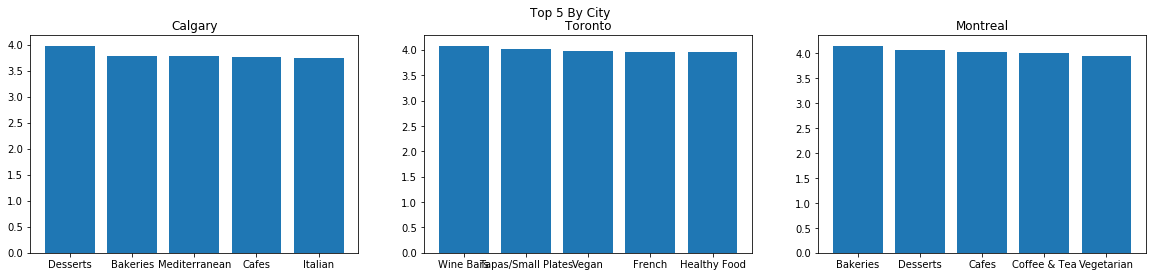

In [247]:
import matplotlib.pyplot as plt
def generate_top_cuisine_chart(df, city_name, num=5):
    labels = df.index.values.tolist()[:num]
    ratings = df['mean'].tolist()[:num]
    plt.title(city_name)
    plt.bar(labels, ratings)
 
    
plt.figure(figsize=(20,4))
plt.suptitle('Top 5 By City')
plt.subplot(131)
generate_top_cuisine_chart(ca_df, 'Calgary')
plt.subplot(132)
generate_top_cuisine_chart(to_df, 'Toronto')
plt.subplot(133)
generate_top_cuisine_chart(mo_df, 'Montreal')

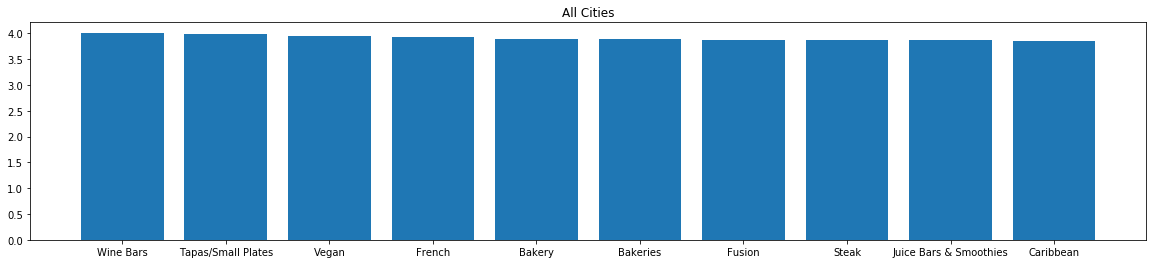

In [248]:
# All cities top 10
plt.figure(figsize=(20,4))
generate_top_cuisine_chart(all_df, 'All Cities', 10)

### Q2: Postal code areas with the highest rated restaurants in each city

In [249]:
#Group by shortened postal code and mean weighted avg rating for that area code and then sort by that rating
def get_highest_rated_for_postal_code(df):
    q1_df = df.groupby(['shortened_postal_codes']).mean()
    q1_df = q1_df.sort_values(by=['overall_rating'], ascending=False)
    return q1_df

In [250]:
#Change postal code to have just the first three digits for broader postal code areas
postal_codes = weighted_df['postal_code'].tolist()
shortened_codes = []

for pc in postal_codes:
    if pc != np.nan:
        shortened_pc = str(pc)[:-3]
    else:
        shortened_pc = None
    shortened_codes.append(shortened_pc)
    
weighted_df['shortened_postal_codes'] = shortened_codes
weighted_df


#Dataframes for each city grouped by shortened postal code with mean weighted average of rating

q1_calgary_df = weighted_df[weighted_df['city'] == 'Calgary'].copy();
q1_calgary_df = get_highest_rated_for_postal_code(q1_calgary_df)


q1_toronto_df = weighted_df[weighted_df['city'] == 'Toronto'].copy();
q1_toronto_df = get_highest_rated_for_postal_code(q1_toronto_df)


q1_montreal_df = weighted_df[weighted_df['city'] == 'Montreal'].copy();
q1_montreal_df = get_highest_rated_for_postal_code(q1_montreal_df)


In [251]:
q1_calgary_df['city'] = 'Calgary'
q1_calgary_df = q1_calgary_df.drop(['num_ratings','rating','review_count','stars','total_ratings','y_wt_rate','yelp_wt','z_wt_rate','zomato_wt'],1)
q1_calgary_df

,overall_rating,city
shortened_postal_codes,,
T2T,3.940352,Calgary
T2R,3.936082,Calgary
T3E,3.932999,Calgary
T2G,3.877487,Calgary
T2V,3.865257,Calgary
T2N,3.855676,Calgary
T3C,3.847107,Calgary
T1Y,3.826573,Calgary
T2L,3.814727,Calgary


In [252]:
q1_toronto_df['city'] = "Toronto"
q1_toronto_df = q1_toronto_df.drop(['num_ratings','rating','review_count','stars','total_ratings','y_wt_rate','yelp_wt','z_wt_rate','zomato_wt'],1)
q1_toronto_df

,overall_rating,city
shortened_postal_codes,,
M4B,5.000000,Toronto
M3N,4.500000,Toronto
M9N,4.461468,Toronto
M2P,4.326241,Toronto
M5K,4.266740,Toronto
...,...,...
M1W,3.200000,Toronto
,3.195038,Toronto
M2H,3.125000,Toronto


In [253]:
q1_montreal_df['city'] = "Montreal"
q1_montreal_df = q1_montreal_df.drop(['num_ratings','rating','review_count','stars','total_ratings','y_wt_rate','yelp_wt','z_wt_rate','zomato_wt'],1)
q1_montreal_df

,overall_rating,city
shortened_postal_codes,,
H3R,4.530435,Montreal
H1R,4.500000,Montreal
H3M,4.282260,Montreal
H3J,4.250326,Montreal
H2M,4.150704,Montreal
...,...,...
H4B,3.322030,Montreal
H3L,3.320588,Montreal
H1N,3.263158,Montreal


#### Getting postal code area with highest rated restaurants

The first value of each dataframe contains the highest rated postal code.

In [254]:
# We will combine all of the highest rated postal codes and their weighet avg ratings to see which postal code out of calgary, toronto and montreal
calgary_highest = q1_calgary_df.iloc[0]
toronto_highest = q1_toronto_df.iloc[0]
montreal_highest = q1_montreal_df.iloc[0]

In [255]:
highest_rated_codes = pd.DataFrame()

highest_rated_codes = highest_rated_codes.append(calgary_highest,ignore_index=False)
highest_rated_codes = highest_rated_codes.append(toronto_highest,ignore_index=False)
highest_rated_codes = highest_rated_codes.append(montreal_highest,ignore_index=False)

highest_rated_codes 

,city,overall_rating
T2T,Calgary,3.940352
M4B,Toronto,5.000000
H3R,Montreal,4.530435


### Results Q2: Postal code aread with highest rated restuarants in Canada

As we can see the highest rated postal area codes in Canada are T2T for Calgary, M4B for Toronto and H2J for Montreal. 

- T2T in Calgary maps to the central South areas of Bankview, Upper and lower Mount Royal, and Altador
- M4B in Toronto maps to the Eastern areas of Parkview Hills, Topham Park and Woodbine Gardens
- H3R in Montreal maps to the Western area of Mt Royal